# Analysing Land Cover Change with Python

This notebook contains python code and exercises to learn about analysing land cover change with raster data. We will use data from the UKCEH [Land Cover Map products](https://www.ceh.ac.uk/ukceh-land-cover-maps) to conduct analyses similar to those presented by Clare Rowland of [UKCEH](https://www.ceh.ac.uk/) in her [ialeUK Landscape Connections](https://iale.uk/landscape-connections) talk [from 8:34](https://youtu.be/NZZvE6OH9bI?t=514). 

<img src="https://www.ceh.ac.uk/sites/default/files/Land%20Cover%20Change-GB-rgb.jpg" width="400px"></img>

Code is provided for analysis of data for years 1990, 2015 and the change between them. Exercises are then suggested to complete similar tasks but using data for 2000. 

## Table of Contents

0. <a href=#section0>Data and Setup</a>

1. <a href=#section1>Reading Raster Data</a>

2. <a href=#section2>Plotting Categorical Rasters</a>

3. <a href=#section3>Analysing Aggregate Change</a>

4. <a href=#section4>Analysing Zonal Change</a>

5. <a href=#section5>Analysing Pixel-by-Pixel Change</a>

6. <a href=#section6>Exercises</a>

<a name="section0"></a>
## 0. Setup and Data

In [her talk]((https://youtu.be/NZZvE6OH9bI?t=514)), Clare Rowland presents results from the [Land Cover Change 1990-2015 product](https://www.ceh.ac.uk/services/land-cover-change-1990-2015). That product uses a raster data data structure, as is common for land use/cover data. Those data are [provided](https://catalogue.ceh.ac.uk/documents/fe69e8bb-5fe6-43be-8681-baa54df1399a) at 25m resolution, resulting in a file 7.5GB in size. Such a large data product is unwieldy for the learning activities in this notebook, so here we work with data at 1km resolution. 

The data that we read and work with here are from the `data/output/` directory. The `output` here indicates that these data files are not the original 1km data downloaded from the [UK CEH LCM repository](https://catalogue.ceh.ac.uk/documents/c0078881-7d5a-4641-91e2-c271426bc8a1), but data which have been subjected to some data wrangling, namely:
- properly setting the `nodata` value to `0.0` in rasters
- setting a consistent `CRS` format across all rasters
- re-projecting the vector data to be consistent with the rasters (i.e. using [ESPG 27700](https://epsg.io/27700))
- cropping the data to the extent of Wales only (from previous coverage for entirety of GB)
- re-classifying from 20+ land cover classes to six to be consistent with the [Land Cover Change 1990-2015 product](https://www.ceh.ac.uk/services/land-cover-change-1990-2015).

See `uk-lcm-wrangling.ipynb` for the code for this wrangling. 

It's good practice to import all the packages we require for our analysis in one place at the outset. 

In [6]:
import rasterio as rio
import rasterio.mask
from rasterio.plot import show
#from descartes import PolygonPatch

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import plotly.graph_objects as go

import seaborn as sns
import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
import copy

from sklearn import metrics
from rasterstats import zonal_stats

<a name="section1"></a>
## 1. Reading Raster Data

When working with raster data in Python it is useful to remember the distinction between spatial data and *geo*spatial data:
- geospatial is when we can reference spatial data to locations on the earth's surface
- otherwise, without referencing to locations on the earth's surface, data are 'merely' spatial 

As we'll see below for raster data in python using the `rasterio` package, the geospatial information is held in `DatasetReader` metadata while the spatial data are held in `numpy ndarrays`.

Last week when opening raster data we opened directly as a [numpy `ndarray`]() using something like:

```python
with rasterio.open('file path') as src:
    var_r = src.read(1)
```

We only needed the spatial data last week, but this week we'll be combining raster data with vector data which will require working with the geospatial aspect of the data. So this week, we'll need to get into more of the detail needed to really understand how to work with [rasterio](https://rasterio.readthedocs.io). See a quick tutorial on reading data with rasterio [here](https://rasterio.readthedocs.io/en/latest/topics/reading.html).

Note that above we imported `rasterio` as follows:

```python
import rasterio as rio
```

### Rasterio `DatasetReader` includes metadata

We can use the `open` [function](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) directly to create an object:

In [7]:
lcm2020_gb6_dr = rio.open("data/output/lcm2020_gb6.tif")

Note this is a `DatasetReader` object and we haven't actually read the data into memory yet:

In [8]:
print(type(lcm2020_gb6_dr))

<class 'rasterio.io.DatasetReader'>


`DatasetReader` objects are useful because we can access information about the raster data before reading what can be very large data files into memory (taking up computer resources we might need for other data). See the attributes of `DatasetReader` objects [here](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader).

For example, we can access the metadata of the raster file using the `meta` method on the `DatasetReader` object:  

In [9]:
lcm2020_gb6_dr.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 651,
 'height': 1216,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 5000.0,
        0.0, -1000.0, 1221000.0)}

The `meta` attribute is a `dict` containing the basic metadata of the dataset. It contains information on:
- driver: the file format ([using](https://rasterio.readthedocs.io/en/latest/api/rasterio.drivers.html) GDAL standard); examples include GeoTiff and NetCDF
- dtype: the data type(s) of band(s) in the dataset (in index order); examples include int and float
- nodata: the value used to indicate pixels that do not contain valid data
- width: the number of pixels in the horizontal
- height: the number of pixels in the vertical
- count: the number of bands in the dataset
- crs: the coordinate reference system (i.e. the definition of the real-world system in which a raster’s pixels are located) - _important to note here is units of system (here, we have metres)_
- transform: the parameters by which pixel coordinates (in the data grid) are transformed into coordinates in the CRS (see more [here](https://rasterio.readthedocs.io/en/latest/topics/georeferencing.html))

To access the individual elements of the metadata, we can do so as we would for any other `dict`. For example to the the `transform` information:

In [10]:
lcm2020_gb6_dr.meta['transform']

Affine(1000.0, 0.0, 5000.0,
       0.0, -1000.0, 1221000.0)

We can also access the [bounds](https://rasterio.readthedocs.io/en/latest/api/rasterio._base.html?highlight=bounds#id1) (i.e. the spatial limits) of the raster data:

In [11]:
print(lcm2020_gb6_dr.bounds)

BoundingBox(left=5000.0, bottom=5000.0, right=656000.0, top=1221000.0)


This is useful (for example) if we want to confirm the resolution of the data:

In [12]:
#calculate horizontal resolution (right coord - left coord) / count cells
(lcm2020_gb6_dr.bounds[2] - lcm2020_gb6_dr.bounds[0]) / lcm2020_gb6_dr.width

1000.0

In [204]:
lcm2000_gb6_dr = rio.open("data/output/lcm2000_gb6.tif")

In [205]:
print(type(lcm2000_gb6_dr))

<class 'rasterio.io.DatasetReader'>


In [207]:
lcm2000_gb6_dr.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 651,
 'height': 1216,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 5000.0,
        0.0, -1000.0, 1221000.0)}

In [208]:
lcm2000_gb6_dr.meta['transform']

Affine(1000.0, 0.0, 5000.0,
       0.0, -1000.0, 1221000.0)

In [209]:
print(lcm2000_gb6_dr.bounds)

BoundingBox(left=5000.0, bottom=5000.0, right=656000.0, top=1221000.0)


In [210]:
(lcm2000_gb6_dr.bounds[2] - lcm2000_gb6_dr.bounds[0]) / lcm2000_gb6_dr.width

1000.0

In [211]:
lcm2000_gb6_np = lcm2000_gb6_dr.read()

In [212]:
print(type(lcm2000_gb6_np))

<class 'numpy.ndarray'>


In [213]:
print(lcm2000_gb6_np.shape)

(1, 1216, 651)


### Raw Raster Data is a `ndarray`
If we want to start working with the actual data themselves, we need to read the data using from the `DatasetReader` object using the `read()` method:

In [13]:
lcm2020_gb6_np = lcm2020_gb6_dr.read()

The `read()` method returns a [numpy n-dimensional array](https://numpy.org/doc/stable/reference/arrays.ndarray.html) object, known as `ndarray`:

In [14]:
print(type(lcm2020_gb6_np))

<class 'numpy.ndarray'>


If you think you think you will be working with raster data in python (with rasterio) in future, it will be worthwhile spending some time learning about the `numpy.ndarray` data structure. [This tutorial](https://numpy.org/doc/stable/user/absolute_beginners.html#whats-the-difference-between-a-python-list-and-a-numpy-array) might be a good place to start. 

You can think of an `ndarray` as being a bit like a regular python `list`, except `ndarray`s:
- can be multi-dimensional (e.g. 2D like a raster grid)
- use less memory than `list`s and are faster to operate on
- must have all elements of the same type (e.g. all `int`)

Because a `ndarray` can be multidimensional, it's important to check their `shape` once they have been read into memory:

In [15]:
print(lcm2020_gb6_np.shape)

(1, 1216, 651)


This shows us that our `ndarray` is _three_ dimensional! But aren't we supposed to be working with a two-dimensional raster grid? 

**Rasterio `read()` usually loads data as three dimensional** (unless you specify otherwise - see 'Reading Specific Layers below). This is because it is common for remotely sensed data to have several 2D layers (or 'bands') corresponding to different wavelengths of light for locations of the earth's surface. Or the data could be several 2D land cover maps, where each map layer is a year (so that we can examine change across space through time). 

Such data might be thought of as a _data cube_. The image below may help to visualise the sort of data structure we're working with here - we're working with the cube on the right:

<img src="https://eox.at/images/eodcaas-mosaic-data-cube-kopp.png" width="600px"></img>

However, in our case here we have only a _single_ layer, so our data really are two-dimensional (with 232 cells vertical and 197 cells horizonal). Check you can see how the shape of our `ndarray` corresponds to the output from `meta` above for the `DatasetReader` object:

`'width': 197,
 'height': 232,
 'count': 1`
 
The `count` here indicates that we have only one layer. Despite only having one layer, **rasterio will still read the data as a three dimensional `ndarray`**. This is important to remember so that we can appropriately access the raster data. 

For example, matplotlib's `imshow` [function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) is useful to:

> Display data as an image, i.e., on a 2D regular raster.

What happens if we try to plot our three-dimensional `ndarray`?  (un-comment the code and run it - you _should_ get an error here) 

In [15]:
#plt.imshow(lcm2020_gb6_np, cmap='viridis')

Matplotlib's `imshow` doesn't know how to plot 3D data.

However, rasterio's [plotting function](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show) (`show`) can handle 3D data and assumes we want to plot the first layer if we don't specify which layer we want:

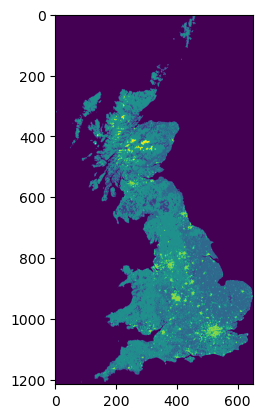

<AxesSubplot: >

In [16]:
#from rasterio.plot import show
show(lcm2020_gb6_np, cmap='viridis')

If we did want to use matplotlib's `imshow` function (or any other function that wants to work with the 2D array) we need to specify the 2D data directly. 

To get to the 2D map data we want, we need to 'slice' out the layer we want by indexing on the first dimension. Here we need to index the first element (as we only have one layer). So, to plot a map of raster data with matplotlib's `imshow` we use `lcm2015_wales6_np`:

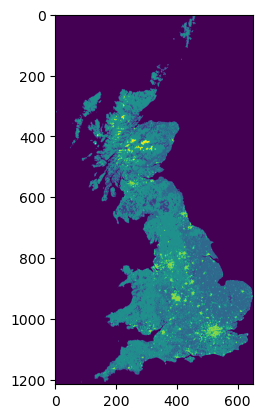

In [17]:
plt.imshow(lcm2020_gb6_np[0], cmap='viridis')

If we had more than one layer in our data, we might access other elements (e.g. `lcm2015_wales6_np[1]` or whatever). 

### Reading Specific Layers
As we have only one layer here (or if we had multiple layers but only wanted to work with one), we could tell rasterio that we _only want to read that layer_ when using the `read()` method:

In [18]:
lcm2020_gb6 = lcm2020_gb6_dr.read(1)

This makes our life a _little_ easier as we can forget all about that 3D stuff and just work with a 2D `ndarray`:

In [19]:
print(lcm2020_gb6.shape)

(1216, 651)


For example, plotting with matplotlib now just requires passing the object (and not specifying any dimensions): 

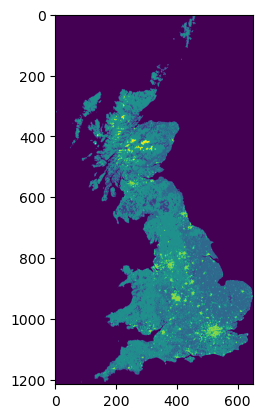

In [20]:
plt.imshow(lcm2020_gb6, cmap='viridis')

### The Importance of CRS

_So why don't we just work with the 2D data all the time??_ 

Well, before we decide that we can just use these raw 2D data from now on, there's one more thing to highlight: _coordinate reference systems_ (CRS). The CRS is the definition of the real-world system in which a raster’s pixels are located (read more [here](https://datacarpentry.org/organization-geospatial/03-crs/)). 

If we ignore the CRS and work with the 2D numpy `ndarray` we are essentially ignoring where the pixels are located on the earth's surface. We can see that in the last plot - the axes are simply numbered horizontally from 0 on the left and vertically from 0 at the top. We can see we have ~250 rows and ~180 columns. 

Ignoring the CRS might be fine for some things (e.g. if you're just working with a single raster) but it's important when we're working with multiple data files to ensure everything aligns properly. For example, below we are going to use some polygons with the raster data; the CRS is important to define where the data in each file are located and therefore how the data align.

Remember from above that the CRS information is actually contained in the `DatasetReader` object. When we plot using the rasterio `show` with the `DatasetReader` object, we can see that the CRS is being used - _the co-ordinates on the axis are different from when using just the 2D data_:

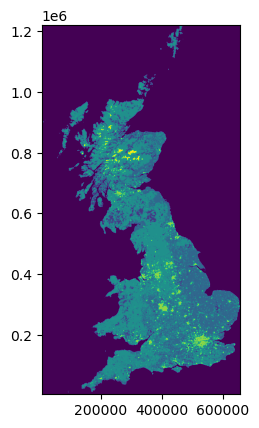

<AxesSubplot: >

In [21]:
#from rasterio.plot import show
show(lcm2020_gb6_dr, cmap='viridis')

Now, the axes run from `200,000` to `350,000` - these values correspond with the `bounds` we checked above and are in the units of the CRS (in this case metres). 

#### Summary
Hopefully, working through all this stuff hasn't been _too_ confusing, but it's important to try to understand. The key issues are:
1. the `DatasetReader` object contains the metadata for the raster, including spatial information like the `CRS`
2. once `read` into memory, the data are a three-dimensional numpy `ndarray` 
3. we can access two-dimensional `ndarray` slices by indexing the 'layer' we want (e.g. `lcm2015_wales6_np[0]` to get the first layer) 

If you're unsure about this please ask, but often working with different objects is the best way to learn. So let's move on...

### Summary

Despite all the code (and explanation above), all we really need to do to read our raster data is the following:

In [22]:
lcm1990_gb6_dr = rio.open("data/output/lcm1990_gb6.tif")   #DatasetReader
lcm1990_gb6 = lcm1990_gb6_dr.read(1)                       #2d numpy ndarray

But at least now you understand what these two lines of code are doing...

In [23]:
print(type(lcm1990_gb6_dr))
print(type(lcm1990_gb6))
print(lcm1990_gb6.shape)

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(1216, 651)


<a name="section2"></a>
## 2. Plotting Categorical Rasters

Up to this point we have quickly plotted raster maps using the `viridis` palette and not worrying too much about the visualisation. For example:

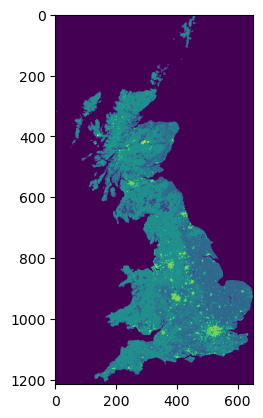

In [24]:
plt.imshow(lcm1990_gb6, cmap='viridis')

But this (continuous) colour palette isn't really appropriate for our (categorical) map. To improve on things, we'll create our own matplotlib `ListedColormap` [docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html) to set the raster colours, and combine with matplotlib `Patch` [docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html) to create a corresponding legend. An [EarthLab tutorial](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/customize-matplotlib-raster-maps/) provides the inspiration and this [matplotlib tutorial](https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#sphx-glr-tutorials-colors-colormap-manipulation-py) is also useful.  

First, we define the colours as a list before converting this to a `ListedColormap` object that matplotlib can use:

In [25]:
#from matplotlib.colors import ListedColormap
lc6_colors = ["white", "darkgreen", "lightyellow", "lightgreen", "blue", "black", "grey"]
lc6_cmap = ListedColormap(lc6_colors)   
print(type(lc6_cmap))

<class 'matplotlib.colors.ListedColormap'>


Note above we used colour names that matplotlib will recognise, but there are [various other ways to define colours in matplotlib](https://matplotlib.org/stable/tutorials/colors/colors.html#sphx-glr-tutorials-colors-colors-py).

Also, note that we included _seven_ colours, as we also need to define a colour for the 'NoData' value (`0`). 

We simply pass the `ListedColormap` to the `cmap` argument of the matplotlib plotting function. For example, to compare land cover for 1990 vs 2015: 

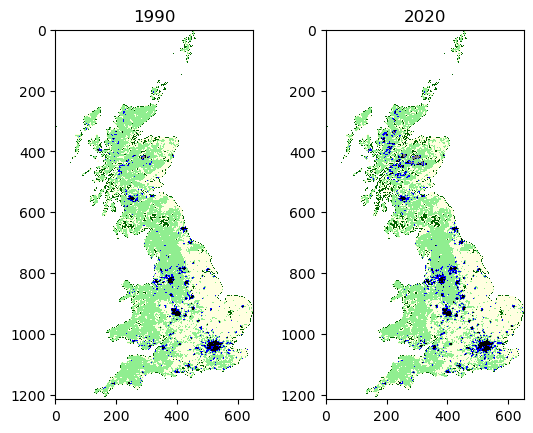

In [26]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(lcm1990_gb6, cmap=lc6_cmap)
axs[1].imshow(lcm2020_gb6, cmap=lc6_cmap)

axs[0].set_title("1990")
axs[1].set_title("2020")

plt.show()

Next, we need to add a legend. 

To do this we first create a list holding the names to use in the legend, before combining that list with the colours list from above into a `dict`

In [27]:
# Define class names for the legend
lc6_names = [
    "No Data",
    "Woodland",
    "Cropland",
    "Grassland",
    "Water",
    "Built-up",
    "Other"
]

# use zip to combine two lists into a dict
legend_labels = dict(zip(lc6_colors, lc6_names))

print(legend_labels)

{'white': 'No Data', 'darkgreen': 'Woodland', 'lightyellow': 'Cropland', 'lightgreen': 'Grassland', 'blue': 'Water', 'black': 'Built-up', 'grey': 'Other'}


We then create our matplotlib `Patch`es using a loop over the `dict`:

In [28]:
#from matplotlib.patches import Patch
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

Now we use the list of `Patch`es created with the matplotlib `legend` [function](https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html): 

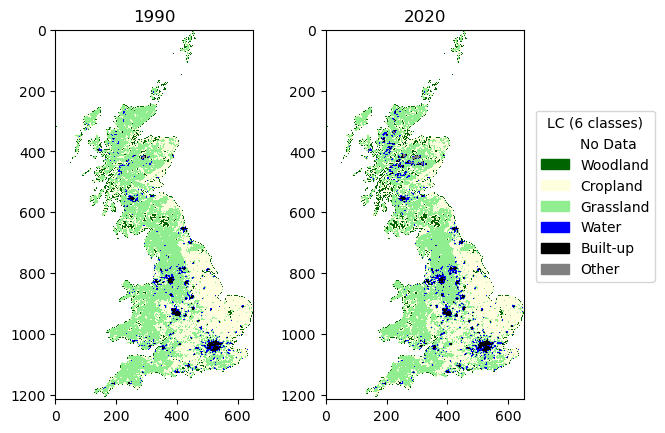

In [29]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(lcm1990_gb6, cmap=lc6_cmap)
axs[1].imshow(lcm2020_gb6, cmap=lc6_cmap)

axs[0].set_title("1990")
axs[1].set_title("2020")

#add legend
axs[1].legend(
    handles=patches,
    bbox_to_anchor=(1.7, 0.8),  #positioning of the legend, often need to play with this
    facecolor="white",
    title='LC (6 classes)')

plt.show()

This is looking much more appropriate for our categorical land cover data!

If we want to 'zoom-in' on an area of our raster, we can do this by specifying a slice of the `ndarray` (a bit like how we would slice a `list`):

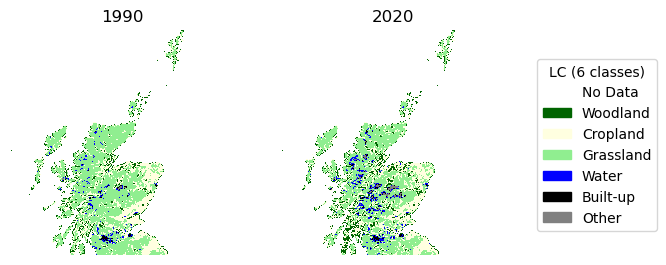

In [31]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(lcm1990_gb6[0:600,0:600], cmap=lc6_cmap)
axs[1].imshow(lcm2020_gb6[0:600,0:600], cmap=lc6_cmap)

axs[0].set_title("1990")
axs[1].set_title("2020")

axs[1].legend(handles=patches,
          bbox_to_anchor=(1.7, 0.9),  #positioning of the legend, often need to play with this
          facecolor="white",
             title='LC (6 classes)')

axs[0].set_axis_off()
axs[1].set_axis_off()

plt.show()

fig.savefig('scotland land use.png', dpi=150, bbox_inches='tight', facecolor='white')

<a name="section3"></a>
## 3. Analysing Aggregate Change

In this section we're going to examine land cover change across the whole of Wales for 1990-2015 with our 1km data. Our aim is to produce a bar plot that shows increases or decreases in land area for each land cover class between the two points in time. This should look something like the bar chart at the top of this notebook (and shown in the [Clare Rowland's talk at 10:50](https://youtu.be/NZZvE6OH9bI?t=650)), but without the fancy graphics and for all classes (not just four). 

We can quickly identify the unique values in our land cover maps and how many times they are observed (i.e. how many pixels fall in each land cover class). Because are data are `numpy` objects (i.e. `ndarray`'s) we can use `numpy`'s `.unique` [function](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) to [count the occurrence of each value](https://stackoverflow.com/a/28663910):

In [36]:
unique, counts = np.unique(lcm1990_gb6, return_counts=True)  #get the unique values and counts
counts1990_6 = dict(zip(unique, counts))                         #combine them into a dict for easier viewing

unique, counts = np.unique(lcm2020_gb6, return_counts=True)
counts2020_6 = dict(zip(unique, counts))

print(counts1990_6)
print('\n')
print(counts2020_6)

{0: 562362, 1: 15860, 2: 61401, 3: 137424, 4: 1418, 5: 11958, 6: 1193}


{0: 562337, 1: 20926, 2: 59957, 3: 129569, 4: 1497, 5: 14892, 6: 2438}


In [35]:
numpy.delete(lcm1990_gb6, obj, axis=None)

<class 'numpy.ndarray'>


Because our data are 1km resolution, each pixel represents 1 sq km. So our counts of pixels (created above) are actually also measures of land area in sq km and we can use them for our bar plot. 

But it will be easier to make a plot from these data if we convert the `dict` to a Pandas `DataFramme`. We can create `DataFrame`s from `dict`s using the `from_dict` Pandas method:

In [40]:
counts_df = pd.DataFrame.from_dict(counts1990_6,orient="index") #tell pandas to use keys as indexes 
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
        0
0  562362
1   15860
2   61401
3  137424
4    1418
5   11958
6    1193


We could do this again for the other `dict` and then `join` or `merge` the two `DataFrame`s. 

But another trick is to pass `from_dict` a list of `dict`s that share `key`s (which our `dict`s do):

In [41]:
counts_df = pd.DataFrame.from_dict([counts1990_6,counts2020_6])
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
        0      1      2       3     4      5     6
0  562362  15860  61401  137424  1418  11958  1193
1  562337  20926  59957  129569  1497  14892  2438


Let's also create a `dict` containing labels for the land covers and add that to the `DataFrame`: 

In [42]:
lclabs = dict(zip(np.arange(0,7).tolist(), lc6_names))
lclabs

{0: 'No Data',
 1: 'Woodland',
 2: 'Cropland',
 3: 'Grassland',
 4: 'Water',
 5: 'Built-up',
 6: 'Other'}

In [43]:
counts_df = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2020_6])
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
         0         1         2          3      4         5      6
0  No Data  Woodland  Cropland  Grassland  Water  Built-up  Other
1   562362     15860     61401     137424   1418     11958   1193
2   562337     20926     59957     129569   1497     14892   2438


Things will be easier for plotting if we have our table such that Land Covers are rows. To rotate a `DataFrame` we can [transpose](https://en.wikipedia.org/wiki/Transpose) the data using the `.T` pandas method:

In [44]:
counts_df = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2020_6]).T
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
           0       1       2
0    No Data  562362  562337
1   Woodland   15860   20926
2   Cropland   61401   59957
3  Grassland  137424  129569
4      Water    1418    1497
5   Built-up   11958   14892
6      Other    1193    2438


And we should re-label our columns:

In [45]:
counts_df = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2020_6]).T
counts_df.columns = ['Land Cover', '1990', '2020']
counts_df

Land Cover    1990    2020
0    No Data  562362  562337
1   Woodland   15860   20926
2   Cropland   61401   59957
3  Grassland  137424  129569
4      Water    1418    1497
5   Built-up   11958   14892
6      Other    1193    2438

Finally, when plotting by more than one variable (as we want to do below) it will be much easier if the data are in ['long', rather than 'wide'](https://anvil.works/blog/tidy-data) format. Ensuring you understand the difference will make understanding what we do in the next code block much easier: 
- Wide data sets record values for each variable in a separate column (so column title indicate the context of the value)
- Long data sets record values in a single column with other columns containing the context of each value

'Long data' are also sometimes known as [narrow](https://en.wikipedia.org/wiki/Wide_and_narrow_data) or [tidy](https://r4ds.had.co.nz/tidy-data.html) data.

To convert from wide to long for our data, we use the `melt` [method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) using the Land Cover labels as `id_vars` (ID variables) and the year columns as `value_vars` (value variables): 

In [46]:
counts_df_long = pd.melt(counts_df, id_vars=['Land Cover'], value_vars=['1990','2020'])
counts_df_long

Land Cover variable   value
0     No Data     1990  562362
1    Woodland     1990   15860
2    Cropland     1990   61401
3   Grassland     1990  137424
4       Water     1990    1418
5    Built-up     1990   11958
6       Other     1990    1193
7     No Data     2020  562337
8    Woodland     2020   20926
9    Cropland     2020   59957
10  Grassland     2020  129569
11      Water     2020    1497
12   Built-up     2020   14892
13      Other     2020    2438

To make life easier, we'll rename the columns in our new 'long' `DataFrame`:

In [47]:
counts_df_long.rename(columns={'variable':'Year','value':'cells'}, inplace = True)
counts_df_long

Land Cover  Year   cells
0     No Data  1990  562362
1    Woodland  1990   15860
2    Cropland  1990   61401
3   Grassland  1990  137424
4       Water  1990    1418
5    Built-up  1990   11958
6       Other  1990    1193
7     No Data  2020  562337
8    Woodland  2020   20926
9    Cropland  2020   59957
10  Grassland  2020  129569
11      Water  2020    1497
12   Built-up  2020   14892
13      Other  2020    2438

Now we're in a position to plot our data! Note that the explanation above worked through things slowly, but the code needed to re-organise our data is 'simply':

```python
lclabs = dict(zip(np.arange(0,7).tolist(), lc6_names))
counts_df = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2015_6]).T
counts_df.columns = ['Land Cover', '1990', '2015']
counts_df_long = pd.melt(counts_df, id_vars=['Land Cover'], value_vars=['1990','2015'])
counts_df_long.rename(columns={'variable':'Year','value':'cells'}, inplace = True)
```

Now to nicely plot a bar plot of land area (sq km) by land cover and year, we'll use Seaborn's `catplot`: 

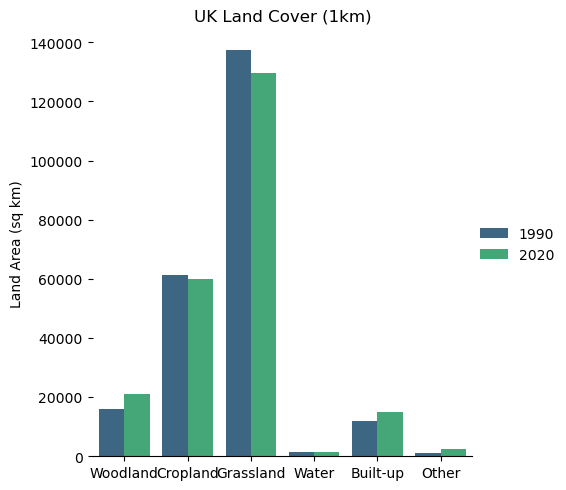

In [48]:
# Draw a nested barplot by land cover and year
g = sns.catplot(
    data=counts_df_long[counts_df_long['Land Cover'] != 'No Data'],   #don't plot NoData pixels!
    kind="bar",
    x='Land Cover', y='cells', 
    hue="Year",
    palette="viridis"
)
g.despine(left=True)
g.set_axis_labels("", "Land Area (sq km)")
g.legend.set_title("")
plt.title("UK Land Cover (1km)")
plt.show()

Plotting area by _two_ categorical variables (land cover and year) was facilitated by using data in 'long' format.

This is total land area for each cover by year, but what about land cover _change_ between the years?

To plot this we need to create a new variable from the difference between the years. This is most easily done with our 'wide' `DataFrame`: 

In [49]:
counts_df['Diffc-9020'] = counts_df['2020'] - counts_df['1990']
counts_df

Land Cover    1990    2020 Diffc-9020
0    No Data  562362  562337        -25
1   Woodland   15860   20926       5066
2   Cropland   61401   59957      -1444
3  Grassland  137424  129569      -7855
4      Water    1418    1497         79
5   Built-up   11958   14892       2934
6      Other    1193    2438       1245

Because we only want to plot a _single_ variable (the `Diffc-9015`) we can work with the 'wide' format data here:

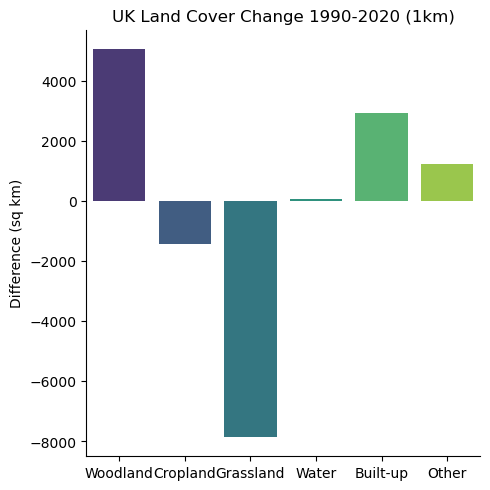

In [50]:
g = sns.catplot(
    data=counts_df[counts_df['Land Cover'] != 'No Data'], 
    kind='bar',
    x='Land Cover', y='Diffc-9020',
    palette="viridis"
)
g.despine()
g.set_axis_labels("", "Difference (sq km)")
plt.title("UK Land Cover Change 1990-2020 (1km)")
plt.show()

_How does this aggregate change for 1990-2015 for Wales (using 1km data) compare to the change observed over the entirety of Great Britain (using 25m data)?_ 

<a name="section4"></a>
## 4. Analysing Zonal Change

The analysis of our data above was aggregated for our entire area (Wales). Below we'll analyse data on a pixel-by-pixel basis. But sometimes we want to work at a level in between, using zones that belong to some kind of vector geography. This is where raster _zonal statistics_ come in:

> Zonal Statistics uses groupings to calculate statistics for specified zones. [source](https://gisgeography.com/zonal-statistics/)

The statistics are summary statistics (e.g. mean, median, standard deviation) of all the pixels that fall in each zone. The zones might be watersheds, biomes or ecoregions (physically) or states, countries, counties or census districts (socio-econmically).  

In her talk, Clare Rowland presented zonal statistics of land cover change for UK counties as choropleth maps (remember them?). We'll make similar choropleth maps, but also think about how we could improve on what was presented. 

### Reading polygon data

To create county-level summaries of change we need polygons to define these zones. These polygons will need to have the same coordinate reference system as the raster data so that they align spatially. 

We'll read the data using GeoPandas:

In [105]:
GB = gpd.read_file('data/output/Counties_and_Unitary_Authorities_April2019_GB_BGC_osbg.geojson').set_index('ctyua19nm')
GB.head()

objectid  ctyua19cd ctyua19nmw   bng_e   bng_n     long  \
ctyua19nm                                                                       
Hartlepool                   1  E06000001             447157  531476 -1.27023   
Middlesbrough                2  E06000002             451141  516887 -1.21099   
Redcar and Cleveland         3  E06000003             464359  519597 -1.00611   
Stockton-on-Tees             4  E06000004             444937  518183 -1.30669   
Darlington                   5  E06000005             428029  515648 -1.56835   

                            lat  st_areashape  st_lengthshape  \
ctyua19nm                                                       
Hartlepool            54.676159  9.364022e+07    69232.916248   
Middlesbrough         54.544670  5.387847e+07    42081.032562   
Redcar and Cleveland  54.567520  2.448736e+08    96004.895063   
Stockton-on-Tees      54.556911  2.049584e+08   115262.590755   
Darlington            54.535339  1.974976e+08   105784.983937   

                                                               geometry  
ctyua19nm                                                                
Hartlepool            MULTIPOLYGON (((449613.69168 526077.14023, 449...  
Middlesbrough         MULTIPOLYGON (((451788.84155 520487.74895, 451...  
Redcar and Cleveland  MULTIPOLYGON (((451788.37175 520493.73655, 451...  
Stockton-on-Tees      MULTIPOLYGON (((449243.87660 526122.71596, 449...  
Darlington            POLYGON ((436388.01502 522354.20043, 436282.11...

In these data, each row (polygon) is a county (or unitary authority) for Great Britain. 

Look at the geometry column - what coordinate reference system (CRS) do you think the data are using? The CRS is actually [OSGB 1936 / British National Grid](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid). How do we know this? 
1. We could guess from the file name (_GB_BGC_osbg.geojson_)
2. The file was created by the code in `uk-lcm-wrangling.ipynb` which shows the re-projection
3. Experience of working with data for UK (for which OSBG is commonly used) means the values in the `geometry` column look about right. 

Couldn't we also check the CRS of the GeoDataFrame?

In [106]:
GB.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [107]:
GB.plot()

ValueError: 'box_aspect' and 'fig_aspect' must be positive

Error in callback <function _draw_all_if_interactive at 0x000001AD194D63A0> (for post_execute):


ValueError: 'box_aspect' and 'fig_aspect' must be positive

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 640x480 with 1 Axes>

That looks like a different CRS to what we think it is... What's going on here?

Well, this is a peculiarity of the `geojson` data format (which the data were stored and read in as):
> The coordinate reference system for all GeoJSON coordinates is a geographic coordinate reference system, using the [World Geodetic System 1984 (WGS 84) datum](https://epsg.io/4326), with longitude and latitude units of decimal degrees. [[source]](https://datatracker.ietf.org/doc/html/rfc7946#page-12)

The CRS of `geojson` files is **always** WGS84, even if the data don't use WGS84! How annoying!

So, for data you read in from a `geojson` file, you should always set the CRS of the data yourself. We don't need to re-project our data, rather we just update the `crs` attribute of the data:  

In [108]:
GB.crs = "EPSG:27700"  

C:\Users\noush\anaconda3\envs\sds2022\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


As [the GeoPandas docs show](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.crs.html#geopandas.GeoDataFrame.crs), we can use a code from an 'authority' on CRS, like [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset), to set the `crs` attribute of our data. The EPSG code of OSGB 1936 is `27700` (hence that value used in the code above). You can find ESPG codes for different CRS by [searching epsg.io](https://epsg.io).

Now, let's check we have updated correctly:

In [109]:
GB1.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

Good. So now we should be able to plot the data:

<AxesSubplot: >

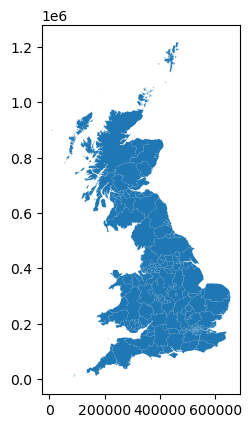

In [110]:
GB.plot()

That looks right! If we hadn't corrected the `crs` attribute, we would have received an error when trying to do that plot (try it for yourself by re-reading the data and plotting without updating the `crs`). 

So that's polygons for the whole of GB. How do we get polygons just for Wales? 

Note that the first letter of the `ctyua19cd` variable (which is the 'county and unitary authority code for 2019') indicates which country (England, Scotland, Wales) the county is located in. We can use that information to filter our GeoDataFrame (with help from the `.str.startswith` method). 

In [111]:
scotland = GB[GB['ctyua19cd'].str.startswith("S")]
scotland

objectid  ctyua19cd ctyua19nmw   bng_e    bng_n  \
ctyua19nm                                                                
Clackmannanshire            152  S12000005             291159   696335   
Dumfries and Galloway       153  S12000006             270645   579857   
East Ayrshire               154  S12000008             255398   624935   
East Lothian                155  S12000010             354854   672351   
East Renfrewshire           156  S12000011             251929   653115   
Na h-Eileanan Siar          157  S12000013             126473   932862   
Falkirk                     158  S12000014             289661   679536   
Highland                    159  S12000017             241026   858306   
Inverclyde                  160  S12000018             227922   670899   
Midlothian                  161  S12000019             330088   659217   
Moray                       162  S12000020             328024   843593   
North Ayrshire              163  S12000021             228984   651640   
Orkney Islands              164  S12000023             348291  1006584   
Scottish Borders            165  S12000026             345891   626135   
Shetland Islands            166  S12000027             434516  1180307   
South Ayrshire              167  S12000028             226544   596270   
South Lanarkshire           168  S12000029             284634   636071   
Stirling                    169  S12000030             255980   708769   
Aberdeen City               170  S12000033             387763   808478   
Aberdeenshire               171  S12000034             352286   816276   
Argyll and Bute             172  S12000035             200740   715442   
City of Edinburgh           173  S12000036             320193   669416   
Renfrewshire                174  S12000038             239305   664698   
West Dunbartonshire         175  S12000039             242904   681587   
West Lothian                176  S12000040             299483   668514   
Angus                       177  S12000041             345518   759594   
Dundee City                 178  S12000042             340291   732145   
East Dunbartonshire         179  S12000045             261240   676154   
Fife                        180  S12000047             339197   704726   
Perth and Kinross           181  S12000048             284304   744186   
Glasgow City                182  S12000049             261534   667033   
North Lanarkshire           183  S12000050             277984   665608   

                          long        lat  st_areashape  st_lengthshape  \
ctyua19nm                                                                 
Clackmannanshire      -3.75344  56.147240  1.589764e+08    9.086602e+04   
Dumfries and Galloway -4.02863  55.096218  6.437726e+09    1.048454e+06   
East Ayrshire         -4.29057  55.496738  1.270369e+09    3.309121e+05   
East Lothian          -2.72435  55.942070  6.792207e+08    1.908342e+05   
East Renfrewshire     -4.36060  55.748680  1.742541e+08    9.178945e+04   
Na h-Eileanan Siar    -6.65722  58.199379  3.097613e+09    3.411468e+06   
Falkirk               -3.77060  55.996040  2.973370e+08    1.406551e+05   
Highland              -4.66091  57.586689  2.616150e+10    4.774842e+06   
Inverclyde            -4.75387  55.900349  1.619220e+08    7.618663e+04   
Midlothian            -3.11738  55.821110  3.552753e+08    1.241325e+05   
Moray                 -3.20187  57.476830  2.237796e+09    4.216957e+05   
North Ayrshire        -4.72479  55.727879  8.855028e+08    3.309405e+05   
Orkney Islands        -2.90028  58.943340  1.013852e+09    1.103199e+06   
Scottish Borders      -2.85866  55.525940  4.739236e+09    4.991495e+05   
Shetland Islands      -1.37344  60.504951  1.467973e+09    2.061880e+06   
South Ayrshire        -4.72901  55.230068  1.224089e+09    3.145442e+05   
South Lanarkshire     -3.83272  55.604530  1.773920e+09    2.800839e+05   
Stirling              -4.32595  56.249531  2.253434e+09    3.346329e+05   
Aberde

<AxesSubplot: >

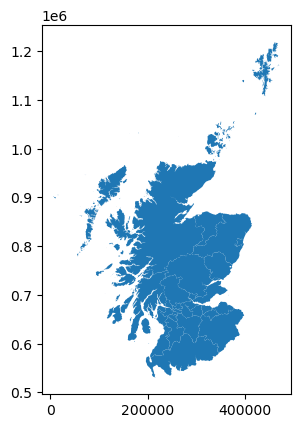

In [112]:
scotland.plot()

<AxesSubplot: >

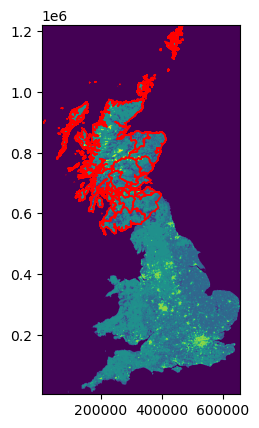

In [114]:
fig,ax1=plt.subplots(1)
show((lcm2020_gb6_dr,1), cmap='viridis',ax=ax1) #rasterio show, reading the first layer from the DatasetReader object
scotland.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1)

Now let's try to plot these polygons on top of our raster data - this is where all the CRS stuff is really important!

<AxesSubplot: >

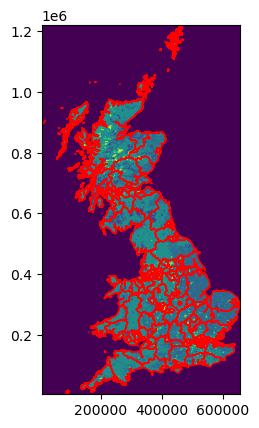

In [115]:
fig,ax1=plt.subplots(1)
show((lcm2020_gb6_dr,1), cmap='viridis',ax=ax1)  #rasterio show, reading the first layer from the DatasetReader object
GB.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1)

Hooray! The Wales polygons align spatially match with the GB raster.

Note, how the code to produce ths plot uses the `rasterio show` function, ensuring that the CRS data for the raster is used when plotting. 

If we tried to use matplotlib to plot the raw, 2D `ndarray` data (which contains no CRS info) we would get an error (you could confirm by running the following code for, example):
```python
#this produces an error
fig,ax1=plt.subplots(1)
plt.imshow(lcm2015_wales6, cmap='viridis', ax=ax1)  #matplotlib with 2d
wales.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1)
```

### Zonal Summary

To do our zonal summary, we can use the `zonal_stats` [function](https://pythonhosted.org/rasterstats/manual.html#zonal-statistics) from the `rasterstats` [package](https://pythonhosted.org/rasterstats/). 

To the `zonal_stats` function we will pass:
- the polygons that specify our zones (as a `GeoDataFrame`)
- the raster data (as `ndarray`) to be summarised
- the geospatial information for the raster data (from the `transform` key of the `meta` attribute (`dict`) of the `rio.DatasetReader` object)
- we specify `categorical=True` so that counts are returned (rather than other inappropriate summary stats for categorical data, like the mean)

So, for our 2015 data:

In [116]:
#from rasterstats import zonal_stats
zs_scotland20_6 = zonal_stats(scotland, lcm2020_gb6,
                           affine=lcm2020_gb6_dr.meta['transform'],
                           categorical=True)
zs_scotland20_6  #ignore -999 warning - NoData already seems to be accounted for... (no zeros)

C:\Users\noush\anaconda3\envs\sds2022\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{1: 16, 2: 32, 3: 92, 5: 17},
 {0: 22, 1: 1640, 2: 325, 3: 4384, 4: 18, 5: 31, 6: 14},
 {1: 212, 2: 3, 3: 992, 4: 9, 5: 28, 6: 31},
 {0: 1, 1: 26, 2: 417, 3: 207, 4: 1, 5: 25},
 {1: 9, 3: 136, 4: 1, 5: 27},
 {0: 79, 1: 8, 3: 2932, 4: 47, 5: 1, 6: 24},
 {1: 42, 2: 69, 3: 135, 5: 54},
 {0: 114, 1: 3364, 2: 317, 3: 20419, 4: 552, 5: 77, 6: 1328},
 {0: 1, 1: 21, 3: 117, 4: 2, 5: 21},
 {1: 27, 2: 82, 3: 215, 4: 2, 5: 27},
 {0: 4, 1: 608, 2: 281, 3: 1243, 5: 42, 6: 57},
 {0: 13, 1: 125, 2: 2, 3: 691, 4: 1, 5: 47, 6: 2},
 {0: 44, 3: 957, 4: 22, 5: 4, 6: 2},
 {0: 3, 1: 722, 2: 817, 3: 3168, 4: 4, 5: 25},
 {0: 124, 3: 1332, 4: 2, 5: 3, 6: 15},
 {0: 2, 1: 333, 2: 31, 3: 813, 4: 4, 5: 36, 6: 1},
 {1: 228, 2: 7, 3: 1447, 4: 2, 5: 81, 6: 9},
 {1: 490, 2: 155, 3: 1449, 4: 73, 5: 28, 6: 52},
 {1: 18, 2: 25, 3: 78, 5: 63},
 {0: 7, 1: 882, 2: 1703, 3: 3463, 4: 6, 5: 66, 6: 181},
 {0: 115, 1: 2083, 2: 35, 3: 4529, 4: 121, 5: 15, 6: 110},
 {0: 1, 1: 19, 2: 80, 3: 56, 5: 106},
 {1: 21, 2: 34, 3: 145, 4: 

You may have received an error that says something like:
```python
UserWarning: Setting nodata to -999; specify nodata explicitly
```

Check the output and if you can't see any `0` `keys` in the `dict` returned then we should be okay (and the 'No Data' `0` values have been recognised properly).

But what is all this output? Well, it's a `dict` for each of our polygons with the pixel count (the `value`s) for each of the land cover IDs (the `key`s) found in the raster. We get counts and not some other summary statistic because our data are categorical). 

Note, that it's not explicitly made clear in the `rasterstats` [docs](https://pythonhosted.org/rasterstats), but we will assume that output is in the same order as the input polygons (as mentioned [here](https://github.com/perrygeo/python-rasterstats/issues/137)).

To make a choropleth map it's useful to have our data in a GeoPandas `GeoDataFrame`. It's relatively easy to convert our raster zonal stats `dict` into a Pandas `DataFrame`:

In [117]:
zs_scotland20_6_pd = pd.DataFrame(zs_scotland20_6)
zs_scotland20_6_pd.head()

1      2     3   5     0     4     6
0    16.0   32.0    92  17   NaN   NaN   NaN
1  1640.0  325.0  4384  31  22.0  18.0  14.0
2   212.0    3.0   992  28   NaN   9.0  31.0
3    26.0  417.0   207  25   1.0   1.0   NaN
4     9.0    NaN   136  27   NaN   1.0   NaN

But now we need to `join` our data to the `wales` `GeoDataFrame` so that we have the geometry information for plotting. 

First, set the index to be the same as `wales` for later joining:

In [123]:
zs_scotland20_6_pd.set_index(scotland.index,inplace=True)

Now set some more useful column names (we set the `15` suffix to distinguish these data for 2015 from those for 1990 later):

In [124]:
zs_scotland20_6_pd.rename(columns=lclabs,inplace=True)  #use the lclabs dict we created above
zs_scotland20_6_pd = zs_scotland20_6_pd.add_suffix('20')
zs_scotland20_6_pd.head()

Woodland15202020  Cropland15202020  Grassland15202020  \
ctyua19nm                                                                      
Clackmannanshire                   16.0              32.0                 92   
Dumfries and Galloway            1640.0             325.0               4384   
East Ayrshire                     212.0               3.0                992   
East Lothian                       26.0             417.0                207   
East Renfrewshire                   9.0               NaN                136   

                       Built-up15202020  No Data15202020  Water15202020  \
ctyua19nm                                                                 
Clackmannanshire                     17              NaN            NaN   
Dumfries and Galloway                31             22.0           18.0   
East Ayrshire                        28              NaN            9.0   
East Lothian                         25              1.0            1.0   
East Renfrewshire                    27              NaN            1.0   

                       Other15202020  
ctyua19nm                             
Clackmannanshire                 NaN  
Dumfries and Galloway           14.0  
East Ayrshire                   31.0  
East Lothian                     NaN  
East Renfrewshire                NaN

And now join to the original wales `GeoDataFrame` (but create a new object rather than over-write):

In [125]:
scotland_gpd = pd.merge(scotland, zs_scotland20_6_pd, how='left', left_index=True, right_index=True)
scotland_gpd.head()

objectid  ctyua19cd ctyua19nmw   bng_e   bng_n  \
ctyua19nm                                                               
Clackmannanshire            152  S12000005             291159  696335   
Dumfries and Galloway       153  S12000006             270645  579857   
East Ayrshire               154  S12000008             255398  624935   
East Lothian                155  S12000010             354854  672351   
East Renfrewshire           156  S12000011             251929  653115   

                          long        lat  st_areashape  st_lengthshape  \
ctyua19nm                                                                 
Clackmannanshire      -3.75344  56.147240  1.589764e+08    9.086602e+04   
Dumfries and Galloway -4.02863  55.096218  6.437726e+09    1.048454e+06   
East Ayrshire         -4.29057  55.496738  1.270369e+09    3.309121e+05   
East Lothian          -2.72435  55.942070  6.792207e+08    1.908342e+05   
East Renfrewshire     -4.36060  55.748680  1.742541e+08    9.178945e+04   

                                                                geometry  \
ctyua19nm                                                                  
Clackmannanshire       MULTIPOLYGON (((290674.509 703671.499, 290009....   
Dumfries and Galloway  MULTIPOLYGON (((207653.609 541738.872, 207676....   
East Ayrshire          POLYGON ((258813.515 645129.307, 258733.010 64...   
East Lothian           MULTIPOLYGON (((351116.011 686149.004, 351032....   
East Renfrewshire      POLYGON ((258954.209 656913.104, 259036.709 65...   

                       Woodland15202020  Cropland15202020  Grassland15202020  \
ctyua19nm                                                                      
Clackmannanshire                   16.0              32.0                 92   
Dumfries and Galloway            1640.0             325.0               4384   
East Ayrshire                     212.0               3.0                992   
East Lothian                       26.0             417.0                207   
East Renfrewshire                   9.0               NaN                136   

                       Built-up15202020  No Data15202020  Water15202020  \
ctyua19nm                                                                 
Clackmannanshire                     17              NaN            NaN   
Dumfries and Galloway                31             22.0           18.0   
East Ayrshire                        28              NaN            9.0   
East Lothian                         25              1.0            1.0   
East Renfrewshire                    27              NaN            1.0   

                       Other15202020  
ctyua19nm                             
Clackmannanshire                 NaN  
Dumfries and Galloway           14.0  
East Ayrshire                   31.0  
East Lothian                     NaN  
East Renfrewshire                NaN

And now we can make a plot of, for example, total Grassland in 2015 by county: 

<AxesSubplot: >

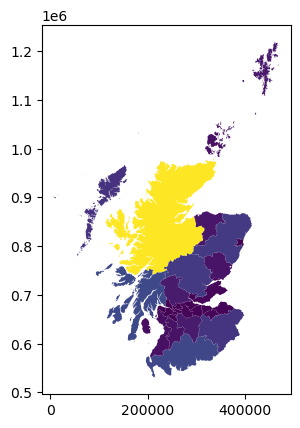

In [127]:
scotland_gpd.plot('Grassland15202020')

Cool! But let's improve that plot by specifying the classification and providing a legend:

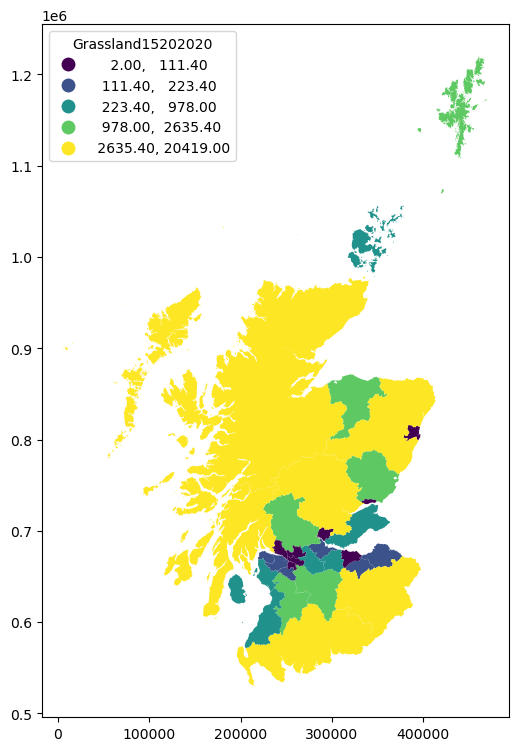

In [131]:
col = 'Grassland15202020'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

This is a vector map summarising raster data. Check you understand the steps we have taken to create this map:
1. use `zonal_stats` to summarise raster cells by polygon
2. convert output from `zonal_stats` to a Pandas `DataFrame`
3. join the zonal summaries `DataFrame` to an existing `GeoDataFrame`
4. plot the summary for one land cover type from the `GeoDataFrame` 

This figure still isn't perfect (think about whether we have a _spatially intensive_ or a _spatially extensive_ variable... ), but it will do for now because really what we want to plot is land cover change by county (as in Clare's talk). 

So to do that we need to calculate zonal stats for 1990 and join them to our `GeoDataFrame`:

In [134]:
zs_scotland90_6 = zonal_stats(scotland_gpd, lcm1990_gb6,
                           affine=lcm1990_gb6_dr.meta['transform'],
                           categorical=True)

zs_scotland90_6_pd = pd.DataFrame(zs_scotland90_6)
zs_scotland90_6_pd.set_index(scotland_gpd.index,inplace=True)
zs_scotland90_6_pd.rename(columns=lclabs,inplace=True)
zs_scotland90_6_pd = zs_scotland90_6_pd.add_suffix('90')
scotland_gpd = scotland_gpd.join(zs_scotland90_6_pd, how='left')

C:\Users\noush\anaconda3\envs\sds2022\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Let's check we've got those new columns in our `GeoDataFrame`:

In [136]:
scotland_gpd.columns

Index(['objectid', 'ctyua19cd', 'ctyua19nmw', 'bng_e', 'bng_n', 'long', 'lat',
       'st_areashape', 'st_lengthshape', 'geometry', 'Woodland15202020',
       'Cropland15202020', 'Grassland15202020', 'Built-up15202020',
       'No Data15202020', 'Water15202020', 'Other15202020', 'Woodland90',
       'Cropland90', 'Grassland90', 'Built-up90', 'No Data90', 'Water90',
       'Other90'],
      dtype='object')

If you can see both `Grassland15` and `Grassland90`, we're in business because now we can calculate Grassland change for 1990-2015: 

In [139]:
scotland_gpd['Grassland_90-15202020'] = scotland_gpd['Grassland15202020'] - scotland_gpd['Grassland90']

And let's plot it!

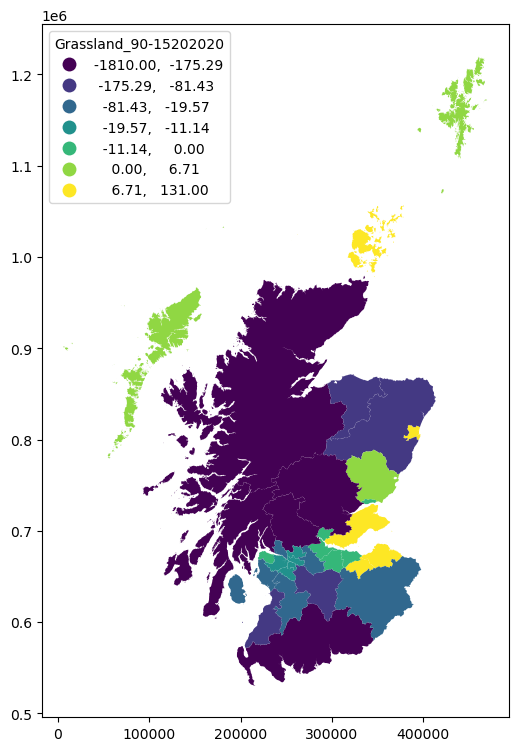

In [142]:
col='Grassland_90-15202020'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=7, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

### Improving maps of change


What do you think of this map? Can we do better? Yes, we can!

The slide at 12:47 mins in the [ialeUK video](https://youtu.be/NZZvE6OH9bI?t=767) talks about poor symbolisation. 

Let's produce a map of grassland change 1990-2015 in Wales with better symbolisation _and for a better variable_. Specifically, we will:
1. plot a _spatially intensive_ variable of grassland change (i.e. percentage change, not absolute change) 
2. use a divergent colour scheme that appropriately represents increase vs decrease in grassland 

The concepts we are working with here were covered in Section 6 of the Foundations of SDS module.

First, to calculate county-level percentage change we need to create a variable for the total area of each county: 

In [143]:
scotland_gpd['Sum15202020'] = scotland_gpd.loc[:,'Woodland15202020':'Other15202020'].sum(axis=1)   #axis=1 to sum rows

Now use this to calclate the percentage change:

In [145]:
scotland_gpd['Grassland_90-2020Perc'] = 100* scotland_gpd['Grassland_90-15202020'] / scotland_gpd['Sum15202020']

And then plot:

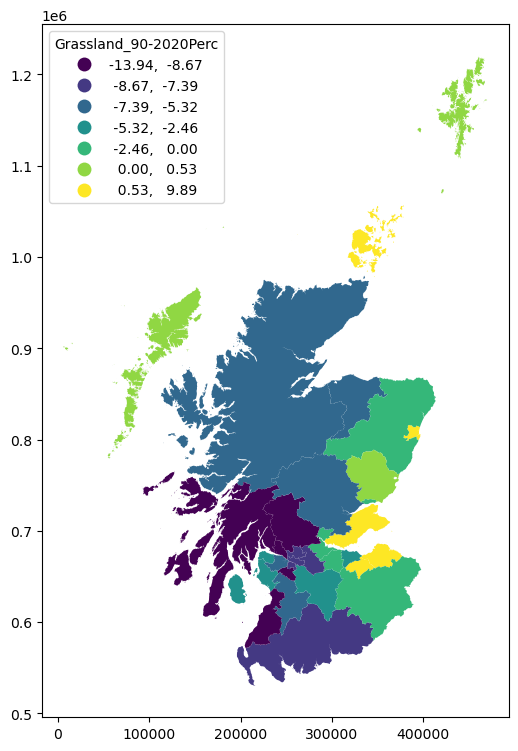

In [147]:
col='Grassland_90-2020Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=7, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

That produces a very different map!

And now let's do a diverging colour palette. We could use a built-in palette, this doesn't set zero at the centre of the scale: 

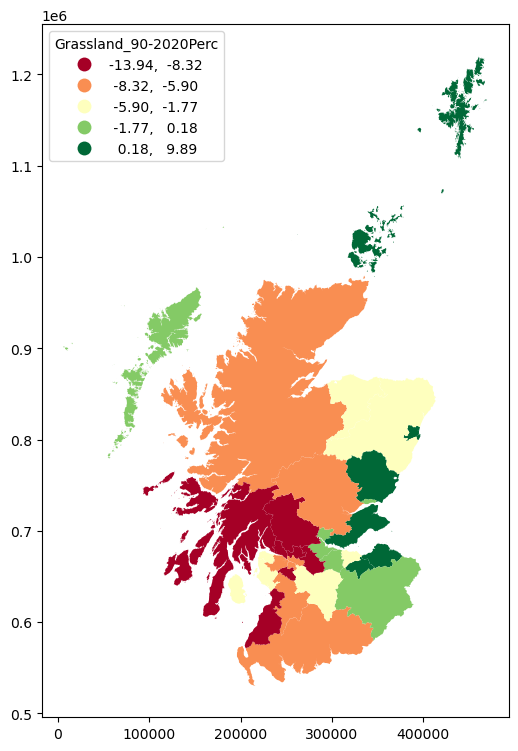

In [148]:
col='Grassland_90-2020Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column=col, cmap='RdYlGn', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

We can do a better job if we use a `UserDefined` classification scheme along with our own `ListedColormap`. 

Let's have a look at the distribution of our variable to decide what classfication and color scheme. 

<AxesSubplot: >

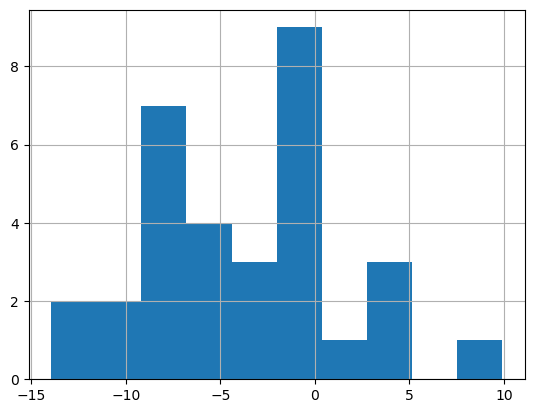

In [149]:
scotland_gpd['Grassland_90-2020Perc'].hist()

To create our own classification we'll use `mapclassify.UserDefined` which [expects](https://pysal.org/mapclassify/generated/mapclassify.UserDefined.html#mapclassify.UserDefined) upper bounds of class bins. 

Let's do five bins, with four <0 and one >0:

In [150]:
#bins from histogram check above but centred on zero
grassbins = [-10,-5,-2.5,0,2.5]  #mapclassify.UserDefined requires upper bounds of class bins 

Now create our own colour map with reds for negative change and greens for positive, using color codes from [colorbrewer2.org](https://colorbrewer2.org). We'll take [colours from a 8-class diverging scheme](https://colorbrewer2.org/#type=diverging&scheme=RdYlGn&n=8) as we want four red hue colours (for <0): 

In [151]:
grasscmap = ListedColormap(["#d73027","#f46d43", "#fdae61", "#fee08b", "#d9ef8b"])

And now we use these bin limits and colors with our usual plotting function:

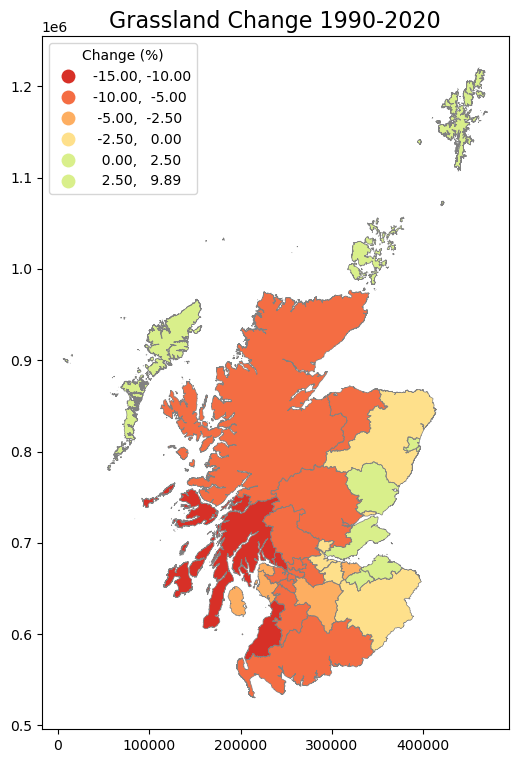

In [154]:
fig, ax = plt.subplots(1, figsize=(9, 9))

scotland_gpd.plot(column='Grassland_90-2020Perc', 
    cmap=grasscmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': grassbins},  #provide the user-created (upper) bin limits here
    legend=True, legend_kwds={"title":"Change (%)","loc": 2}, ax=ax
)

scotland_gpd.plot(ax=ax, facecolor='None', edgecolor='grey', linewidth=0.5)

#edit legend labels
leg = ax.get_legend()
leg.get_texts()[0].set_text('-15.00, -10.00')

plt.title("Grassland Change 1990-2020", size=16)
plt.show()

fig.savefig('Grassland Change - Scotland.png', dpi=150, bbox_inches='tight', facecolor='white')

Hopefully you agree that this map is more appropriate for representing county-level change than those we saw in the video and made above!

<a name="section5"></a>
## 5. Analysing Pixel-by-Pixel Change 

The analysis above was aggregated for the entire raster data (all of Wales) or into zones (in our case, counties). At the finest level of analysis we can analyse change for individual pixels. 

For example, we could count the number of pixel transitions between the different classes - how many pixels were Grassland in 1990 but Woodland in 2015, how many were Grassland in 1990 but Urban in 2015, how many were Woodland in 1990 but Arable in 2015... etc. 

In this section we will calculate all possible transitions using a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) (also known as _cross-tabulation_ or _confusion matrix_) and then visualise all the transitions using a _Sankey Diagram_ (like in Clare Rowland's talk ([at 14:55](https://youtu.be/NZZvE6OH9bI?t=895)).  

### Confusion Matrix

First, we do the cross tabulation. This is relatively straight-forward using the [`confusion_matrix` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) from the `sklearn` package.

We need to `flatten` our 2D `ndarray` to 1D to allow `confusion_matrix` to compare the two maps:

In [158]:
lcm1990_scotland6_f = lcm1990_gb6.flatten()  #flatten from 2d to 1D
lcm2020_scotland6_f = lcm2020_gb6.flatten()  #flatten from 2d to 1D

print(lcm1990_scotland6_f.shape)

(791616,)


Now pass the two flattened maps (i.e. 1D `ndarray`s) to the `confusion_matrix` function:

In [159]:
#from sklearn import metrics
confND = metrics.confusion_matrix(lcm1990_scotland6_f, lcm2020_scotland6_f)
print(confND.shape)
print('\n')
print(confND)

(7, 7)


[[562221     11      7    103      0     15      5]
 [     4  14048    190   1361     19    225     13]
 [    13    792  50885   8622     78    999     12]
 [    89   5919   8730 118951     98   2054   1583]
 [     0     41      6     75   1287      5      4]
 [    10     67     87    216     11  11565      2]
 [     0     48     52    241      4     29    819]]


From [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix), the result is a:
> confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

So for us, this means 1990 values are rows, with the corrsponding 2015 value in columns. 

Remember that the data we used still had the 'No Data' `0` values, so the first row and column are transitions to/from 'No Data'. We could make the contingency table clearer by removing the `No Data` transitions. A short function for this might be as follows:

In [160]:
def stripFirstRows(mydat):
    
    stripped = np.delete(arr=mydat, obj=0, axis=0)     #delete 0-th row
    stripped = np.delete(arr=stripped, obj=0, axis=1)  #delete 0-th col
    
    return stripped

Then using that function:

In [161]:
conf = stripFirstRows(confND)

print(conf.shape)
print('\n')
print(conf)

(6, 6)


[[ 14048    190   1361     19    225     13]
 [   792  50885   8622     78    999     12]
 [  5919   8730 118951     98   2054   1583]
 [    41      6     75   1287      5      4]
 [    67     87    216     11  11565      2]
 [    48     52    241      4     29    819]]


This is better (and we'll use this `ndarray` object again below) but we could make things easier for ourselves by converting to a Pandas `DataFrame` and providing labels for rows (i.e. an index) and column names:

In [162]:
conf_pd = pd.DataFrame(conf,index=lc6_names[1:],columns=lc6_names[1:])
conf_pd

Woodland  Cropland  Grassland  Water  Built-up  Other
Woodland      14048       190       1361     19       225     13
Cropland        792     50885       8622     78       999     12
Grassland      5919      8730     118951     98      2054   1583
Water            41         6         75   1287         5      4
Built-up         67        87        216     11     11565      2
Other            48        52        241      4        29    819

Check you understand the structure of this contingency table. Remember, 1990 values are rows, with the corrsponding 2015 value in columns. 

For example, check you can see how it shows that 146 cells transitioned from Woodland to Grassland, while 412 cells transitioned from Grassland to Woodland. 

How many cells transitioned from Other to Grassland?

**Answer: 38**

### Sankey Diagram

**What is a Sankey diagram?**

> Sankey diagrams are a type of flow diagram in which the width of the arrows is proportional to the flow rate. [source](https://en.wikipedia.org/wiki/Sankey_diagram)

The Cuba (2015) paper [provides](https://doi.org/10.1016/j.landurbplan.2015.03.010) an excellent overview of Sankey diagrams for visualising land cover change. 

[Matplotlib sankey diagrams](https://matplotlib.org/stable/api/sankey_api.html) are a bit lame; the [ones we can make with Plotly](https://www.python-graph-gallery.com/sankey-diagram-with-python-and-plotly) are more like what we want to be able to more closely reproduce the figures in Clare Rowland's talk ([at 14:55](https://youtu.be/NZZvE6OH9bI?t=895)). There are lots of other cool Plotly sankey examples [here](https://coderzcolumn.com/tutorials/data-science/how-to-plot-sankey-diagram-in-python-jupyter-notebook-holoviews-and-plotly)).  

The [plotly docs provide](https://plotly.com/python/sankey-diagram/) a simple example of how to create a Sankey:

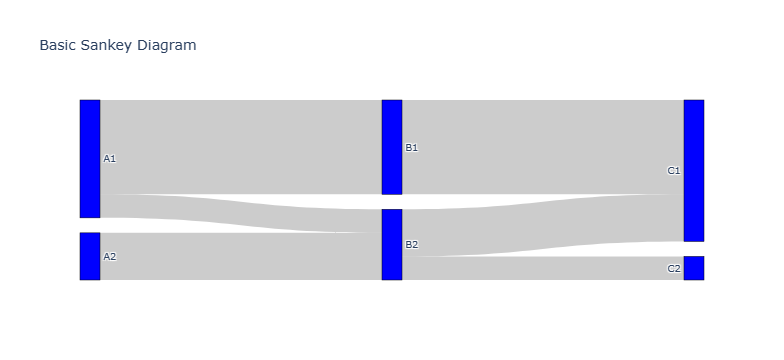

In [163]:
#import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

We'll use this as the basis for our own diagram. 

The key objects we need to create are the `list`s for `source`, `target`, `value` which are incorporated in the the `link`  `dict` (we'll also need to make the `label` list, but we'll do that later).

The `source`s and `target`s are _like_ the land cover class IDs, and the `value`s are the number of pixels transitioning between each. The `source` and `target` are not the actual land cover class IDs - really they are referring to the position of the data within the various lists. Hopefully this will become clear with 'deliberate' mistake we'll make... 

First we make the list of `source`s: 

In [164]:
sourcelc = []
for i in range(0, 6):
    sourcelc += [i] * 6
print(sourcelc)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]


Next the list of `target`s:

In [165]:
targetlc = list(range(0,6))
targetlc *= 6
print(targetlc)

[0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]


And finally the corresponding (`flatten`ed) list of transition counts: 

In [167]:
conf_list = conf.flatten().tolist()  #conf from above!
print(conf_list)

[14048, 190, 1361, 19, 225, 13, 792, 50885, 8622, 78, 999, 12, 5919, 8730, 118951, 98, 2054, 1583, 41, 6, 75, 1287, 5, 4, 67, 87, 216, 11, 11565, 2, 48, 52, 241, 4, 29, 819]


Check you can see why we generated the `source` and `target` values in the order that we did, to ensure they match up with the order in which the transitions appear in the `flatten`ed (1D) contingency table.

Now we combine these three into a `dict` to specify the `link` object needed for the Sankey:

In [168]:
linkslc = dict(source = sourcelc, target = targetlc, value = conf_list)
print(linkslc)

{'source': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5], 'target': [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5], 'value': [14048, 190, 1361, 19, 225, 13, 792, 50885, 8622, 78, 999, 12, 5919, 8730, 118951, 98, 2054, 1583, 41, 6, 75, 1287, 5, 4, 67, 87, 216, 11, 11565, 2, 48, 52, 241, 4, 29, 819]}


And now we should be able to use this `dict` with the `Sankey` function: 

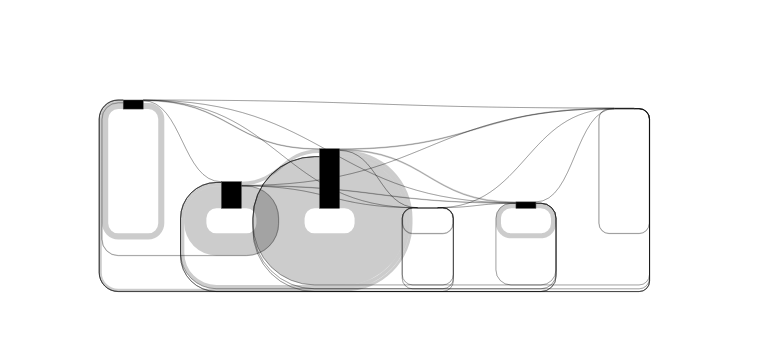

In [169]:
datalc = go.Sankey(link = linkslc)
fig = go.Figure(datalc)

fig.show()

Woah... was that what we were expecting?! Maybe not. 

The problem here is that because we specified the `target` IDs using the same values as the `source` IDs, the Sankey is looping back on itself. Technically this is correct! Think about it...

If we want to visualise the flows from left to right, we are going to need to use different `target` IDs from `source` IDs. 

So let's create a new set of `target` IDs, using values that start from where the `source` IDs finished: 

In [170]:
targetlc2 = list(range(6,12))
targetlc2 *= 6
print(targetlc2)

[6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11]


And use this in our combined `dict` for the `link`:

In [171]:
linkslc2 = dict(source = sourcelc, target = targetlc2, value = conf_list)
print(linkslc2)

{'source': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5], 'target': [6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11], 'value': [14048, 190, 1361, 19, 225, 13, 792, 50885, 8622, 78, 999, 12, 5919, 8730, 118951, 98, 2054, 1583, 41, 6, 75, 1287, 5, 4, 67, 87, 216, 11, 11565, 2, 48, 52, 241, 4, 29, 819]}


Now, for example, instead of 'transitioning' from 0 -> 0 for Woodland pixels that did not change (1603 pixels), we are are using 0 -> 7. Let's see what effect this has: 

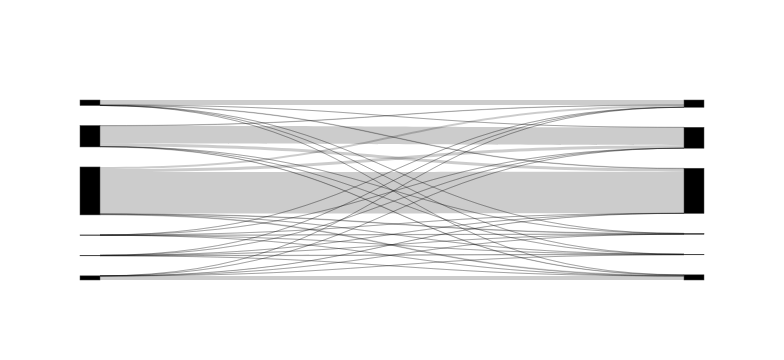

In [172]:
datalc2 = go.Sankey(link = linkslc2)
fig = go.Figure(datalc2)

fig.show()

This is much more like what we want! 

Now to work on making it look prettier and provide more useful info (than 'incoming flow' and 'outgoing flow'). We do this with the attributes in the `node` `dict`. 

First, the labels in the order corresponding to our `source`s and `target`s:

In [173]:
slabels = lc6_names[1:] + lc6_names[1:]  #[1:] because we removed No Data
slabels 

['Woodland',
 'Cropland',
 'Grassland',
 'Water',
 'Built-up',
 'Other',
 'Woodland',
 'Cropland',
 'Grassland',
 'Water',
 'Built-up',
 'Other']

And now the colours we want, again in the same order:

In [174]:
scolors =  lc6_colors[1:] + lc6_colors[1:]  #[1:] because we removed No Data
scolors

['darkgreen',
 'lightyellow',
 'lightgreen',
 'blue',
 'black',
 'grey',
 'darkgreen',
 'lightyellow',
 'lightgreen',
 'blue',
 'black',
 'grey']

And combine these in a `dict` to pass to the `node` argument in the `Sankey` function: 

In [175]:
nodelc = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = slabels ,     
      color = scolors
    )

Finally:

In [233]:
datalc2 = go.Sankey(node=nodelc,link = linkslc2)
fig = go.Figure(datalc2)

fig.title("Sankey Diagram Showing Land Use Change 1990-2020", size=16)

fig.show()

fig.savefig('Sankey diagram.png')

AttributeError: 'Figure' object has no attribute 'title'

Hover your cursor over the various elements of the diagram to check that the values shown for each transition match up to the number of pixels shown in the contingency table above. 

Think about what other things we might do with this plot to make it even better. For example, maybe we could add a title, annotate the year above on right and left, etc. 

<a name="section6"></a>
## 6. Exercises

### Exercise 1. 

Read 2000 raster map data from `data/output/lcm2000_wales6.tif` then plot:
1. the year 2000 data alone _quickly_ with a standard colour palette
2. all three years of data with a categorical colour palette and legend 

Your final three-year plot should look something like this:

<img src="https://www.landscapemodelling.net/png/uk-lcm-wales-exercise1.png" width="500px"></img>

In [191]:
lcm2000_gb6_dr = rio.open("data/output/lcm2000_gb6.tif")   #DatasetReader
lcm2000_gb6 = lcm2000_gb6_dr.read(1)                       #2d numpy ndarray

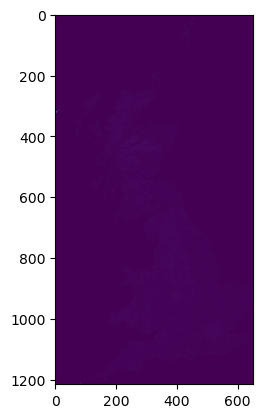

In [214]:
plt.imshow(lcm2000_gb6, cmap='viridis')

In [215]:
# Define color map of the map legend (because class 6 is missing!)
lc5_colors = ["white", "darkgreen", "lightyellow", "lightgreen", "blue", "black"]
lc5_cmap = ListedColormap(lc5_colors)

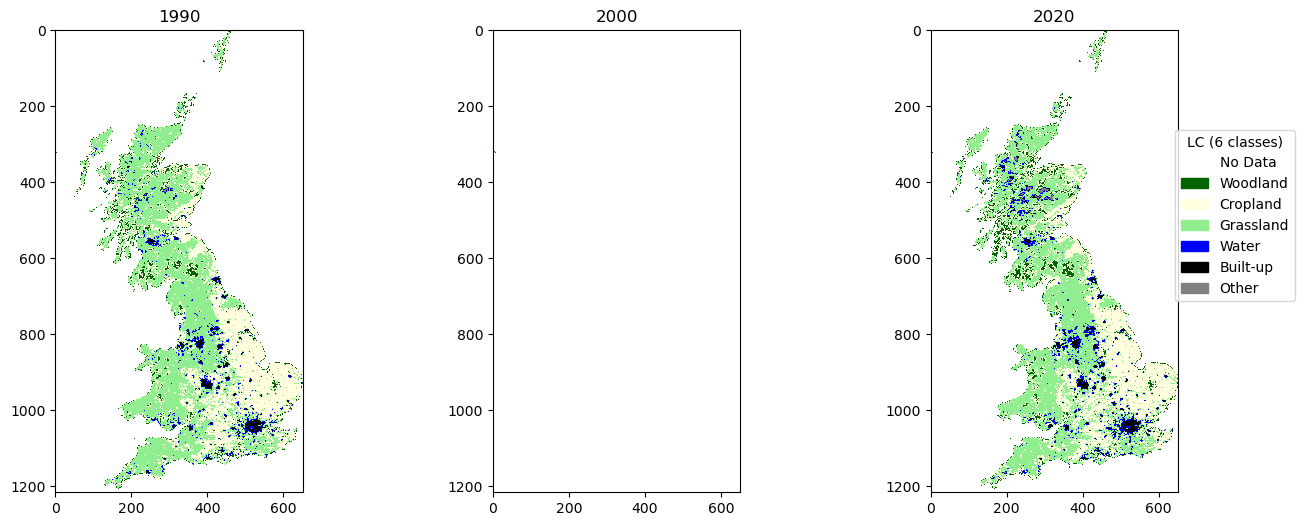

In [216]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))

axs[0].imshow(lcm1990_gb6, cmap=lc6_cmap)
axs[1].imshow(lcm2000_gb6, cmap=lc5_cmap)
axs[2].imshow(lcm2020_gb6, cmap=lc6_cmap)

axs[0].set_title("1990")
axs[1].set_title("2000")
axs[2].set_title("2020")

axs[2].legend(handles=patches,
          bbox_to_anchor=(1.5, 0.8),
          facecolor="white",
             title='LC (6 classes)')

plt.show()

### Exercise 2

Create a barplot to visualise total area of each land cover for all of Wales 1990, 2000, 2015 (i.e add a for 2000 to the plot created above in <a href=#section2>section 2</a>. Your final plot should look something like this:

<img src="https://www.landscapemodelling.net/png/uk-lcm-wales-exercise2.png" width="400px"></img>

In [193]:
unique, counts = np.unique(lcm2000_gb6, return_counts=True)
counts2000_6 = dict(zip(unique, counts))

print(counts2000_6)

{0: 561577, 1: 21990, 2: 61328, 3: 124566, 4: 3164, 5: 14614, 6: 4366, 255: 11}


In [194]:
counts00_list = [lclabs, counts2000_6]

counts00_df = pd.DataFrame.from_dict(counts00_list).T

counts00_df.columns = ['Land Cover', '2000']

counts00_df

Land Cover    2000
0      No Data  561577
1     Woodland   21990
2     Cropland   61328
3    Grassland  124566
4        Water    3164
5     Built-up   14614
6        Other    4366
255        NaN    11.0

In [195]:
counts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Land Cover  7 non-null      object
 1   1990        7 non-null      object
 2   2020        7 non-null      object
 3   Diffc-9020  7 non-null      object
dtypes: object(4)
memory usage: 280.0+ bytes


In [196]:
counts_df = counts_df.merge(counts00_df, how='left', on='Land Cover')   #tried .join but got error, as here https://stackoverflow.com/a/60515993
counts_df

Land Cover    1990    2020 Diffc-9020    2000
0    No Data  562362  562337        -25  561577
1   Woodland   15860   20926       5066   21990
2   Cropland   61401   59957      -1444   61328
3  Grassland  137424  129569      -7855  124566
4      Water    1418    1497         79    3164
5   Built-up   11958   14892       2934   14614
6      Other    1193    2438       1245    4366

In [198]:
counts_df_long = pd.melt(counts_df, id_vars=['Land Cover'], value_vars=['1990','2000','2020'])

counts_df_long.rename(columns={'variable':'Year','value':'cells'}, inplace = True)
counts_df_long

Land Cover  Year   cells
0     No Data  1990  562362
1    Woodland  1990   15860
2    Cropland  1990   61401
3   Grassland  1990  137424
4       Water  1990    1418
5    Built-up  1990   11958
6       Other  1990    1193
7     No Data  2000  561577
8    Woodland  2000   21990
9    Cropland  2000   61328
10  Grassland  2000  124566
11      Water  2000    3164
12   Built-up  2000   14614
13      Other  2000    4366
14    No Data  2020  562337
15   Woodland  2020   20926
16   Cropland  2020   59957
17  Grassland  2020  129569
18      Water  2020    1497
19   Built-up  2020   14892
20      Other  2020    2438

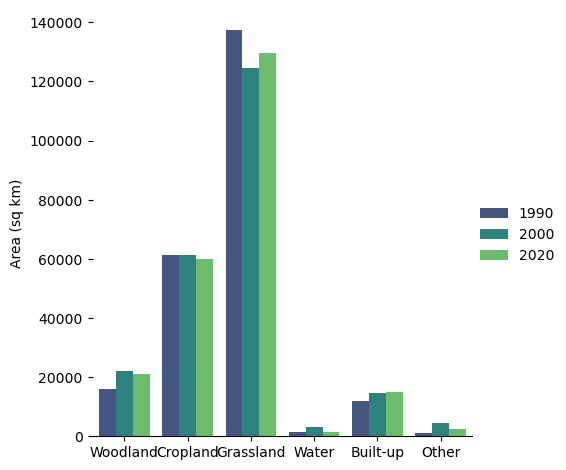

In [199]:
# Draw a nested barplot by land cover and year
g = sns.catplot(
    data=counts_df_long[counts_df_long['Land Cover'] != 'No Data'], 
    kind="bar",
    x='Land Cover', y='cells', hue="Year",
    palette="viridis"
)
g.despine(left=True)
g.set_axis_labels("", "Area (sq km)")
g.legend.set_title("")

### Exercise 3

Create county-level woodland change choropleth maps for 1990-2000 and 2000-2015 to compare change spatially between the two periods. Maps should have appropriate and consistent classification and colour scheme. Your final plot should look something like this:

<img src="https://www.landscapemodelling.net/png/uk-lcm-wales-exercise3b.png" width="500px"></img>

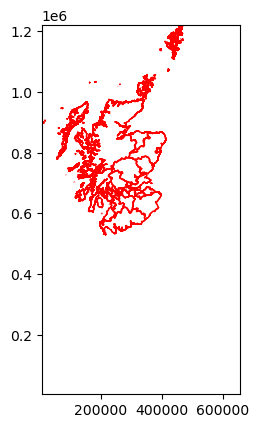

In [218]:
fig,ax=plt.subplots()
show(lcm2000_gb6,transform=lcm2000_gb6_dr.meta['transform'], cmap=lc5_cmap,ax=ax)
scotland_gpd.plot(ax=ax, facecolor='None', edgecolor='red', linewidth=1)
plt.show()

In [219]:
#zonal summary for 2000

zs_scotland00_6 = zonal_stats(scotland_gpd, lcm2000_gb6,
                           affine=lcm2000_gb6_dr.meta['transform'],
                           categorical=True)

zs_scotland00_6_pd = pd.DataFrame(zs_scotland00_6)
zs_scotland00_6_pd.set_index(scotland_gpd.index,inplace=True)
zs_scotland00_6_pd.rename(columns=lclabs,inplace=True)
zs_scotland00_6_pd = zs_scotland00_6_pd.add_suffix('00')
zs_scotland00_6_pd['Sum00'] = zs_scotland00_6_pd.loc[:,'Woodland00':].sum(axis=1)   #sum rows for non-NoData columns  
zs_scotland00_6_pd.head()

C:\Users\noush\anaconda3\envs\sds2022\lib\site-packages\rasterstats\io.py:313: UserWarning:

Setting nodata to -999; specify nodata explicitly



Woodland00  Cropland00  Grassland00  Built-up00  \
ctyua19nm                                                                
Clackmannanshire              5.0        25.0          107          15   
Dumfries and Galloway      1453.0       101.0         4795          22   
East Ayrshire               198.0        32.0         1009          27   
East Lothian                 30.0       403.0          219          18   
East Renfrewshire             8.0         2.0          136          25   

                       Other00  Water00  25500   Sum00  
ctyua19nm                                               
Clackmannanshire           5.0      NaN    NaN   157.0  
Dumfries and Galloway      NaN     63.0    NaN  6434.0  
East Ayrshire              NaN      9.0    NaN  1275.0  
East Lothian               NaN      7.0    NaN   677.0  
East Renfrewshire          NaN      2.0    NaN   173.0

In [220]:
scotland_gpd = scotland_gpd.join(zs_scotland00_6_pd, how='left')
scotland_gpd.columns

Index(['objectid', 'ctyua19cd', 'ctyua19nmw', 'bng_e', 'bng_n', 'long', 'lat',
       'st_areashape', 'st_lengthshape', 'geometry', 'Woodland15202020',
       'Cropland15202020', 'Grassland15202020', 'Built-up15202020',
       'No Data15202020', 'Water15202020', 'Other15202020', 'Woodland90',
       'Cropland90', 'Grassland90', 'Built-up90', 'No Data90', 'Water90',
       'Other90', 'Grassland_90-15202020', 'Sum15202020',
       'Grassland_90-2020Perc', 'Woodland00', 'Cropland00', 'Grassland00',
       'Built-up00', 'Other00', 'Water00', '25500', 'Sum00'],
      dtype='object')

In [222]:
scotland_gpd['Woodland_90-00'] = scotland_gpd['Woodland00'] - scotland_gpd['Woodland90']
scotland_gpd['Woodland_90-00Perc'] = 100* scotland_gpd['Woodland_90-00'] / scotland_gpd['Sum00']

scotland_gpd['Woodland_00-15202020'] = scotland_gpd['Woodland15202020'] - scotland_gpd['Woodland00']
scotland_gpd['Woodland_00-15Perc'] = 100* scotland_gpd['Woodland_00-15202020'] / scotland_gpd['Sum15202020']


count    28.000000
mean      2.376841
std       2.360501
min      -2.547771
25%       1.279601
50%       2.339282
75%       2.996070
max       8.277405
Name: Woodland_90-00Perc, dtype: float64


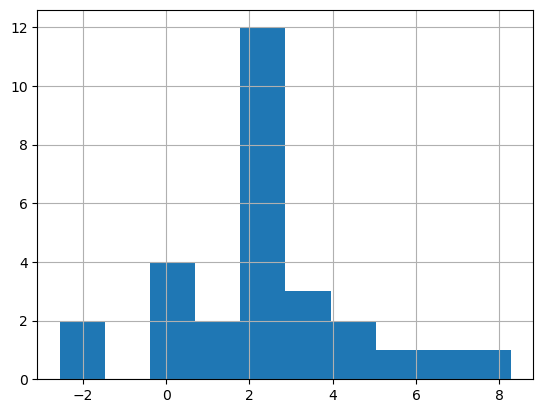

In [225]:
scotland_gpd['Woodland_90-00Perc'].hist()
print(scotland_gpd['Woodland_90-00Perc'].describe())

count    30.000000
mean      2.716949
std       2.960536
min      -2.863535
25%       0.708036
50%       1.866345
75%       5.048127
max       8.064516
Name: Woodland_00-15Perc, dtype: float64


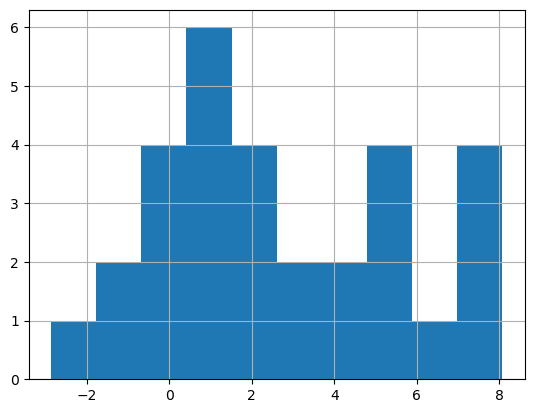

In [226]:
scotland_gpd['Woodland_00-15Perc'].hist()
print(scotland_gpd['Woodland_00-15Perc'].describe())

In [227]:
#bins from histogram check above but centred on zero
woodbins = [-4,-2,0,2,4,6,8]  #mapclassify.UserDefined requires upper bounds of class bins 
#woodbins = list(range(-4,10,2))  #auto generation with range
woodcolors = ["#de77ae","#f1b6da", "#fde0ef", "#e6f5d0", "#b8e186", "#7fbc41", "#4d9221"] #create list for map legend below

#create our own colour map with pink for negative change and greens for positive
#colours from https://colorbrewer2.org/#type=diverging&scheme=PiYG&n=8 (as we want four >0 classes)
woodcmap = ListedColormap(woodcolors)

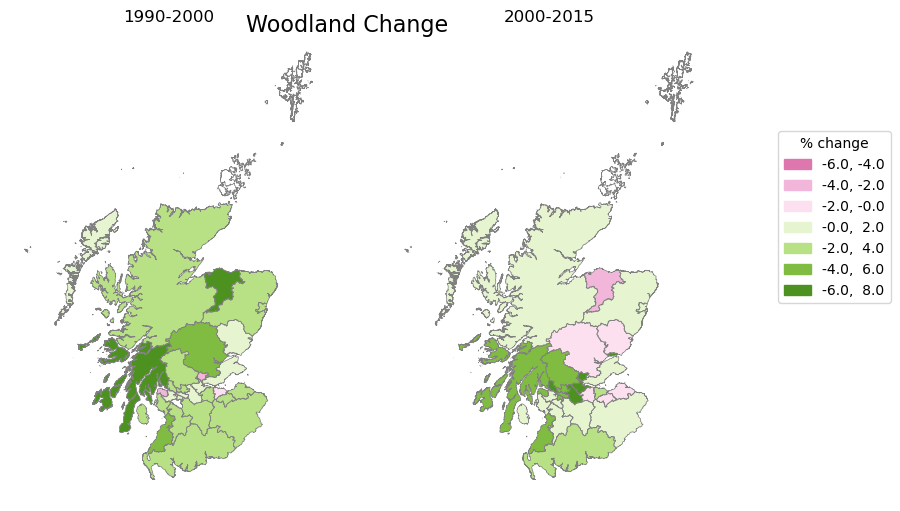

In [228]:
fig, axes = plt.subplots(1,2, figsize=(9, 9))

scotland_gpd.plot(column='Woodland_90-00Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins},
    legend=False, ax=axes[0]
)

scotland_gpd.plot(column='Woodland_00-15Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins},
    legend=False, ax=axes[1]
)

scotland_gpd.plot(ax=axes[0], facecolor='None', edgecolor='grey', linewidth=0.5)
scotland_gpd.plot(ax=axes[1], facecolor='None', edgecolor='grey', linewidth=0.5)

axes[0].set_axis_off()
axes[1].set_axis_off()

axes[0].set_title('1990-2000')
axes[1].set_title('2000-2015')

# use zip to combine two lists into a dict
legend_wood = dict(zip(woodcolors, woodbins))

#from matplotlib.patches import Patch
patches = [Patch(color=color, label=label)
           for color, label in legend_wood.items()]

#add legend!
axes[1].legend(handles=patches,
        bbox_to_anchor=(1.6, 0.8),
        facecolor="white",
        title='% change')

#edit legend labels
leg = axes[1].get_legend()
leg.get_texts()[0].set_text('-6.0, -4.0')
leg.get_texts()[1].set_text('-4.0, -2.0')
leg.get_texts()[2].set_text('-2.0, -0.0')
leg.get_texts()[3].set_text('-0.0,  2.0')
leg.get_texts()[4].set_text('-2.0,  4.0')
leg.get_texts()[5].set_text('-4.0,  6.0')
leg.get_texts()[6].set_text('-6.0,  8.0')


plt.suptitle("Woodland Change", size=16, y=0.775)
plt.show()

### Exercise 4

Build on the code in <a href=#section5>section 5</a> to create a sankey diagram for transitions between the _three_ years 1990 -> 2000 -> 2015. Your final plot should look something like this:

<img src="https://www.landscapemodelling.net/png/uk-lcm-wales-exercise4b.png" width="500px"></img>

In [229]:
#Create sankey diagram for THREE years 1990 -> 2000 -> 2015

source123 = []
for i in range(0, 12):
    source123 += [i] * 6
print(source123)

target12 = list(range(6,12))
target12 *= 6

target23 = list(range(12,18))
target23 *= 6
target123 = target12 + target23
print(target123)

lcm2000_scotland6_f = lcm2000_gb6.flatten()  #flatten from 2d to 1D

lcm2020_scotland6_f = lcm2020_gb6.flatten()  #flatten from 2d to 1D

conf12 = metrics.confusion_matrix(lcm1990_scotland6_f, lcm2000_scotland6_f)
conf23 = metrics.confusion_matrix(lcm2000_scotland6_f, lcm2020_scotland6_f)

values12 = stripFirstRows(conf12)
values23 = stripFirstRows(conf23)

values12 = values12.flatten().tolist()
values23 = values23.flatten().tolist()

values123 = values12 + values23

print(values123)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]
[6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17]
[13397, 258, 1919, 98, 186, 2, 0, 1498, 51169, 7358, 112, 1264, 0, 0, 6913, 9562, 114371, 725, 1931, 3915, 7, 20, 10, 83, 1290, 15, 0, 0, 118, 275, 340, 60, 11165, 0, 0, 41, 48, 417, 185, 52, 449, 0, 0, 0, 0, 0, 0, 0, 0, 15625, 1142, 4780, 24, 373, 43, 0, 564, 49310, 10619, 52, 751, 23, 0, 4361, 8734, 109683, 93, 1052, 581, 0, 149, 86, 696, 1306, 72, 174, 0, 223, 685, 1021, 22, 12644, 17, 0, 4, 0, 2763, 0, 0, 1599, 0, 0, 0, 7, 0, 0, 0, 0]


In [230]:
link123 = dict(source = source123, target = target123, value = values123)
print(link123)

{'source': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11], 'target': [6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17, 12, 13, 14, 15, 16, 17], 'value': [13397, 258, 1919, 98, 186, 2, 0, 1498, 51169, 7358, 112, 1264, 0, 0, 6913, 9562, 114371, 725, 1931, 3915, 7, 20, 10, 83, 1290, 15, 0, 0, 118, 275, 340, 60, 11165, 0, 0, 41, 48, 417, 185, 52, 449, 0, 0, 0, 0, 0, 0, 0, 0, 15625, 1142, 4780, 24, 373, 43, 0, 564, 49310, 10619, 52, 751, 23, 0, 4361, 8734, 109683, 93, 1052, 581, 0, 149, 86, 696, 1306, 72, 174, 0, 223, 685, 1021, 22, 12644, 17, 0, 4, 0, 2763, 0, 0, 1599, 0, 0, 0, 7, 0, 0, 0, 0]}


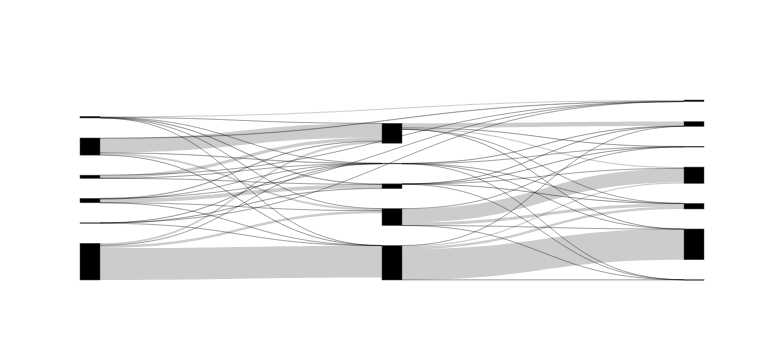

In [231]:
data123 = go.Sankey(link = link123 )
fig = go.Figure(data123)

fig.show()

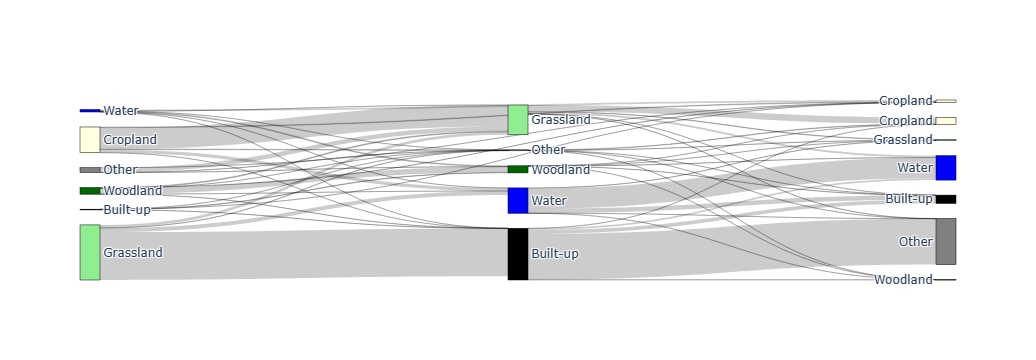

In [234]:
labels123 = lc6_names[1:] + lc6_names[1:] + lc6_names[1:]  #[1:] because we removed No Data

colors123 =  lc6_colors[1:] + lc6_colors[1:] + lc6_colors[1:]  #[1:] because we removed No Data

node123 = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels123 ,     
      color = colors123
    )

data123 = go.Sankey(node=node123,link = link123)
fig = go.Figure(data123)

#add annotations to show year above each bar?
layout =  dict(
        title = 'Changes in land use from 1990, 2000, 2020')
#add source info on the image itself?

fig.show()

### References

Cuba, N. (2015) Research note: Sankey diagrams for visualizing land cover dynamics. _Landscape and Urban Planning_
**139** 163-167 https://doi.org/10.1016/j.landurbplan.2015.03.010

Fuller, R.M.; Smith, G.M.; Sanderson J.M.; Hill, R.A.; Thomson, A.G.; Cox, R.; Brown, N.J.; Clarke, R.T.; Rothery, P.; Gerard, F.F. (2002). Land Cover Map 2000 (1km dominant target class, GB). _NERC Environmental Information Data Centre._ https://doi.org/10.5285/abff8409-0995-48d2-9303-468e1a9fe3df

ONS Geography (2019) Counties and Unitary Authorities (April 2019) Boundaries GB BGC. _Office for National Statistics_ https://geoportal.statistics.gov.uk/datasets/ons::counties-and-unitary-authorities-april-2019-boundaries-gb-bgc/about 

Rowland, C.S.; Morton, R.D.; Carrasco, L.; McShane, G.; O'Neil, A.W.; Wood, C.M. (2017). Land Cover Map 2015 (1km dominant target class, GB). _NERC Environmental Information Data Centre._ https://doi.org/10.5285/c4035f3d-d93e-4d63-a8f3-b00096f597f5

Rowland, C.S.; Marston, C.G.; Morton, R.D.; O’Neil, A.W. (2020a). Land Cover Map 1990 (1km dominant target class, GB) v2. _NERC Environmental Information Data Centre._ https://doi.org/10.5285/f5e3bd00-efd0-4dc6-a454-aa597d84764a

Rowland, C.S.; Marston, C.G.; Morton, R.D.; O’Neil, A.W. (2020b). Land Cover Change 1990-2015 (25m raster, GB). _NERC Environmental Information Data Centre._ https://doi.org/10.5285/07b6e5e9-b766-48e5-a28c-5b3e35abecc0